In [18]:
import gym
import random
import numpy as np
import tensorflow as tf
import time
from gym.envs.registration import register
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

In [2]:
try:
    register(
        id='FrozenLakeNoSlip-v0',
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery':False},
        max_episode_steps=100,
        reward_threshold=0.78, # optimum = .8196
    )
except:
    pass

# env_name = "CartPole-v1"
# env_name = "MountainCar-v0"
# env_name = "MountainCarContinuous-v0"
# env_name = "Acrobot-v1"
# env_name = "Pendulum-v0"
#env_name = "FrozenLake-v0"
env_name = "FrozenLakeNoSlip-v0"
env = gym.make(env_name)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
type(env.action_space)

Observation space: Discrete(16)
Action space: Discrete(4)


gym.spaces.discrete.Discrete

In [4]:
class Agent():
    def __init__(self, env):
        self.is_discrete = \
            type(env.action_space) == gym.spaces.discrete.Discrete
        
        if self.is_discrete:
            self.action_size = env.action_space.n
            print("Action size:", self.action_size)
        else:
            self.action_low = env.action_space.low
            self.action_high = env.action_space.high
            self.action_shape = env.action_space.shape
            print("Action range:", self.action_low, self.action_high)
        
    def get_action(self, state):
        if self.is_discrete:
            action = random.choice(range(self.action_size))
        else:
            action = np.random.uniform(self.action_low,
                                       self.action_high,
                                       self.action_shape)
        return action


In [5]:
class QNAgent(Agent):
    def __init__(self, env, discount_rate=0.97, learning_rate=0.01):
        super().__init__(env)
        self.state_size = env.observation_space.n
        print("State size:", self.state_size)
        
        self.eps = 1.0
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.build_model()
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def build_model(self):
        tf.reset_default_graph()
        self.state_in = tf.placeholder(tf.int32, shape=[1])
        self.action_in = tf.placeholder(tf.int32, shape=[1])
        self.target_in = tf.placeholder(tf.float32, shape=[1])
        
        self.state = tf.one_hot(self.state_in, depth=self.state_size)
        self.action = tf.one_hot(self.action_in, depth=self.action_size)
        
        self.q_state = tf.layers.dense(self.state, units=self.action_size, name="q_table")
        self.q_action = tf.reduce_sum(tf.multiply(self.q_state, self.action), axis=1)
        
        self.loss = tf.reduce_sum(tf.square(self.target_in - self.q_action))
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
    def get_action(self, state):
        q_state = self.sess.run(self.q_state, feed_dict={self.state_in: [state]})
        action_greedy = np.argmax(q_state)
        action_random = super().get_action(state)
        return action_random if random.random() < self.eps else action_greedy
    
    def train(self, experience):
        state, action, next_state, reward, done = ([exp] for exp in experience)
        
        q_next = self.sess.run(self.q_state, feed_dict={self.state_in: next_state})
        q_next[done] = np.zeros([self.action_size])
        q_target = reward + self.discount_rate * np.max(q_next)
        
        feed = {self.state_in: state, self.action_in: action, self.target_in: q_target}
        self.sess.run(self.optimizer, feed_dict=feed)
        
        if experience[4]:
            self.eps = self.eps * 0.99
            
    def __del__(self):
        self.sess.close()
        
agent = QNAgent(env)

Action size: 4
State size: 16


In [56]:
total_reward = 0
rewards= []
epsilon=[]
episodes=[]
Time=[]
for ep in range(100):
    start= time.time()
    state = env.reset()
    done = False
    
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        agent.train((state,action,next_state,reward,done))
        state = next_state
        total_reward += reward
        
        print("s:", state, "a:", action)
        print("Episode: {}, Total reward: {}, eps: {}".format(ep,total_reward,agent.eps))
        env.render()
        rewards.append(total_reward)
        epsilon.append(agent.eps)
        episodes.append(ep)
        with tf.variable_scope("q_table", reuse=True):
            weights = agent.sess.run(tf.get_variable("kernel"))
            print(weights)
        time.sleep(0.05)
        clear_output(wait=True)
        
        
        end= time.time()
        Time.append(end-start)
        
        
         


s: 15 a: 2
Episode: 99, Total reward: 100.0, eps: 0.00018170286290799652
  (Right)
SFFF
FHFH
FFFH
HFFG
[[-0.12998515  0.19776291  0.21196632  0.03683078]
 [-0.12116587 -0.73832422  0.16487423  0.02133873]
 [-0.12401878  0.2688975   0.12805004  0.03030029]
 [-0.13059331 -0.73381197  0.2042091   0.01112008]
 [-0.0559861   0.22029585 -0.46941069 -0.0408525 ]
 [-0.51151425  0.23711365  0.39469928  0.11480302]
 [-0.90449321  0.0070106  -0.4558194  -0.05071493]
 [ 0.53286457 -0.26199168 -0.49814564  0.00523472]
 [-0.04773276 -0.49686736  0.5164966   0.0962453 ]
 [-0.06495078  0.23696123  0.22426522 -0.47192478]
 [-0.014124    0.33514065 -0.48391989  0.04653757]
 [ 0.07620704 -0.33096462 -0.18664992 -0.45220298]
 [ 0.29296517 -0.52699852 -0.16151369  0.39235002]
 [-0.84474802 -0.20621182  0.56313783 -0.01402042]
 [ 0.10238345  0.15914729  0.59535557  0.11964764]
 [ 0.30265772 -0.53107417 -0.40801227  0.26119018]]


In [55]:
print('Time taken for 100 episodes to compute is :{} milliseconds'.format(np.sum(Time)))


Time taken for 100 episodes to compute is :131.82922077178955 milliseconds


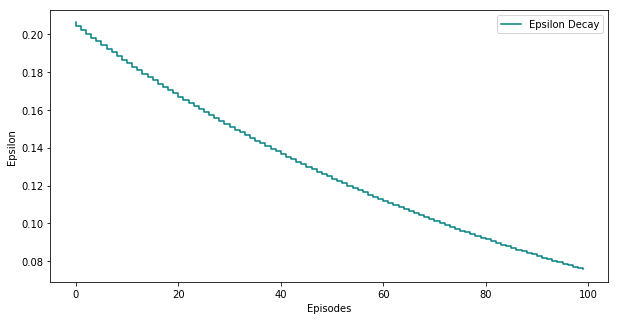

In [36]:
plt.plot(episodes, epsilon, label= 'Epsilon Decay', c= 'teal')

plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.legend(loc=1)

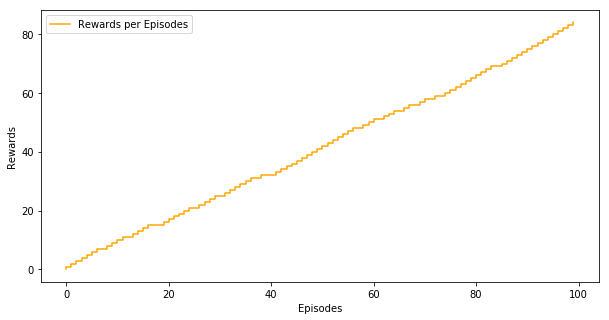

In [37]:
plt.plot(episodes, rewards, label= 'Rewards per Episodes', c= 'orange')

plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc=2)

In [57]:
env.reward_range

(0, 1)